# Predict user converting to paid in a freemium fitness app

## 1. Load libraries and data

In [178]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV 
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb

In [186]:
data = pd.read_csv("C:/Users/VanDoan/OneDrive - Rightpoint/Analysis/strong-app-user-behaviors.csv")

data.head()

,user_id,session_count,avg_session_duration,pageviews_per_session,days_since_last_visit,feature_usage_rate,clicks_on_premium_content,referral_source,state,device_type,...,messages_sent_count,messages_received_count,posts_count,reactions_count,community_sessions_count,number_of_trainings_watched,number_of_trainings_finished,daily_steps,daily_workout_minutes,subscription_status
0,1,9,18.058378,2,18,0.786008,6,ad,New York,mobile,...,3,6,1,5,8,8,3,5113,28,0
1,2,13,20.352634,7,23,0.164727,1,referral,New York,mobile,...,2,3,2,8,8,11,5,4906,31,0
2,3,17,51.809299,4,9,0.400515,3,ad,Illinois,mobile,...,5,3,4,7,9,6,6,4979,33,0
3,4,14,54.858526,4,16,0.195200,5,ad,Florida,desktop,...,2,3,1,5,8,6,6,4911,31,1
4,5,7,22.445929,7,14,0.405861,2,ad,Florida,desktop,...,1,4,1,10,4,5,5,4959,31,0


## 2. Exploratory data analysis EDA

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user_id                        10000 non-null  int64  
 1   session_count                  10000 non-null  int64  
 2   avg_session_duration           10000 non-null  float64
 3   pageviews_per_session          10000 non-null  int64  
 4   days_since_last_visit          10000 non-null  int64  
 5   feature_usage_rate             10000 non-null  float64
 6   clicks_on_premium_content      10000 non-null  int64  
 7   referral_source                10000 non-null  object 
 8   state                          10000 non-null  object 
 9   device_type                    10000 non-null  object 
 10  number_of_visits_last_week     10000 non-null  int64  
 11  number_of_visits_last_30_days  10000 non-null  int64  
 12  messages_sent_count            10000 non-null  

In [197]:
print('number of paid and free users', '\n', data['subscription_status'].value_counts())
print()
print('percentage of paid and free users', '\n', data['subscription_status'].value_counts(normalize=True))

number of paid and free users 
 subscription_status
0    7196
1    2804
Name: count, dtype: int64

percentage of paid and free users 
 subscription_status
0    0.7196
1    0.2804
Name: proportion, dtype: float64


In [6]:
data.columns

Index(['user_id', 'session_count', 'avg_session_duration',
       'pageviews_per_session', 'days_since_last_visit', 'feature_usage_rate',
       'clicks_on_premium_content', 'referral_source', 'state', 'device_type',
       'number_of_visits_last_week', 'number_of_visits_last_30_days',
       'messages_sent_count', 'messages_received_count', 'posts_count',
       'reactions_count', 'community_sessions_count',
       'number_of_trainings_watched', 'number_of_trainings_finished',
       'daily_steps', 'daily_workout_minutes', 'subscription_status'],
      dtype='object')

In [187]:
features = ['session_count', 'avg_session_duration',
       'pageviews_per_session', 'days_since_last_visit', 'feature_usage_rate',
       'clicks_on_premium_content', 
       'number_of_visits_last_week', 'number_of_visits_last_30_days',
       'messages_sent_count', 'messages_received_count', 'posts_count',
       'reactions_count', 'community_sessions_count',
       'number_of_trainings_watched', 'number_of_trainings_finished',
       'daily_steps', 'daily_workout_minutes']

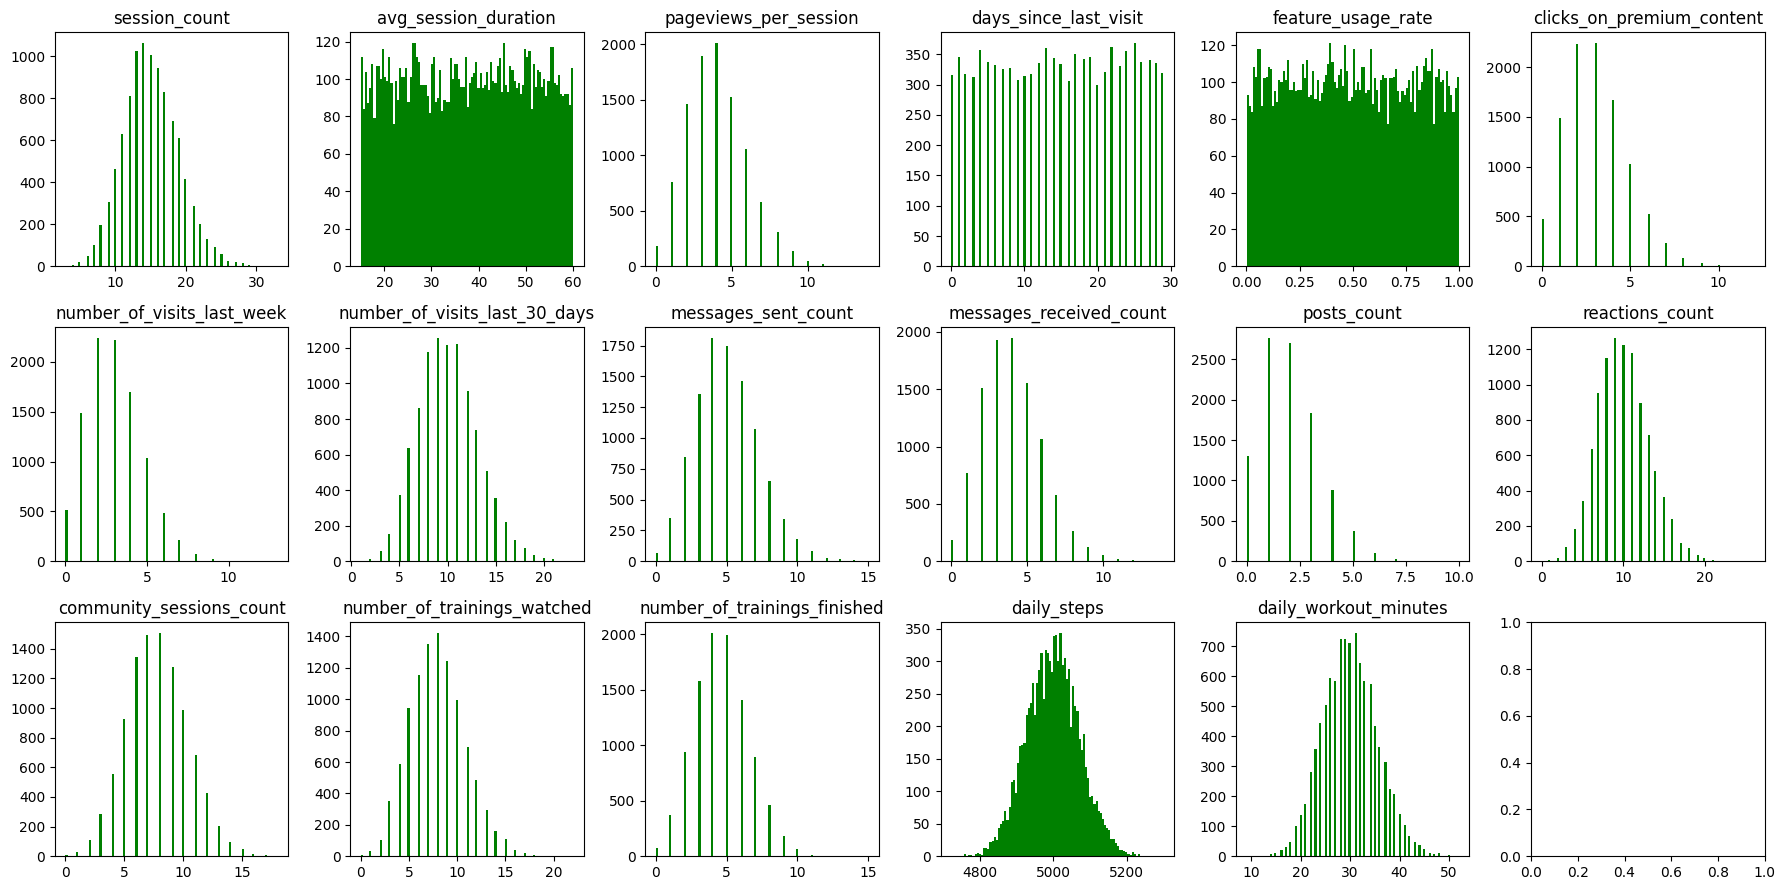

In [124]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for feature, ax in zip(features, axes.ravel()):
    ax.hist(data[feature], bins=100, color='green')
    ax.set_title(feature)

plt.tight_layout()

<Axes: >

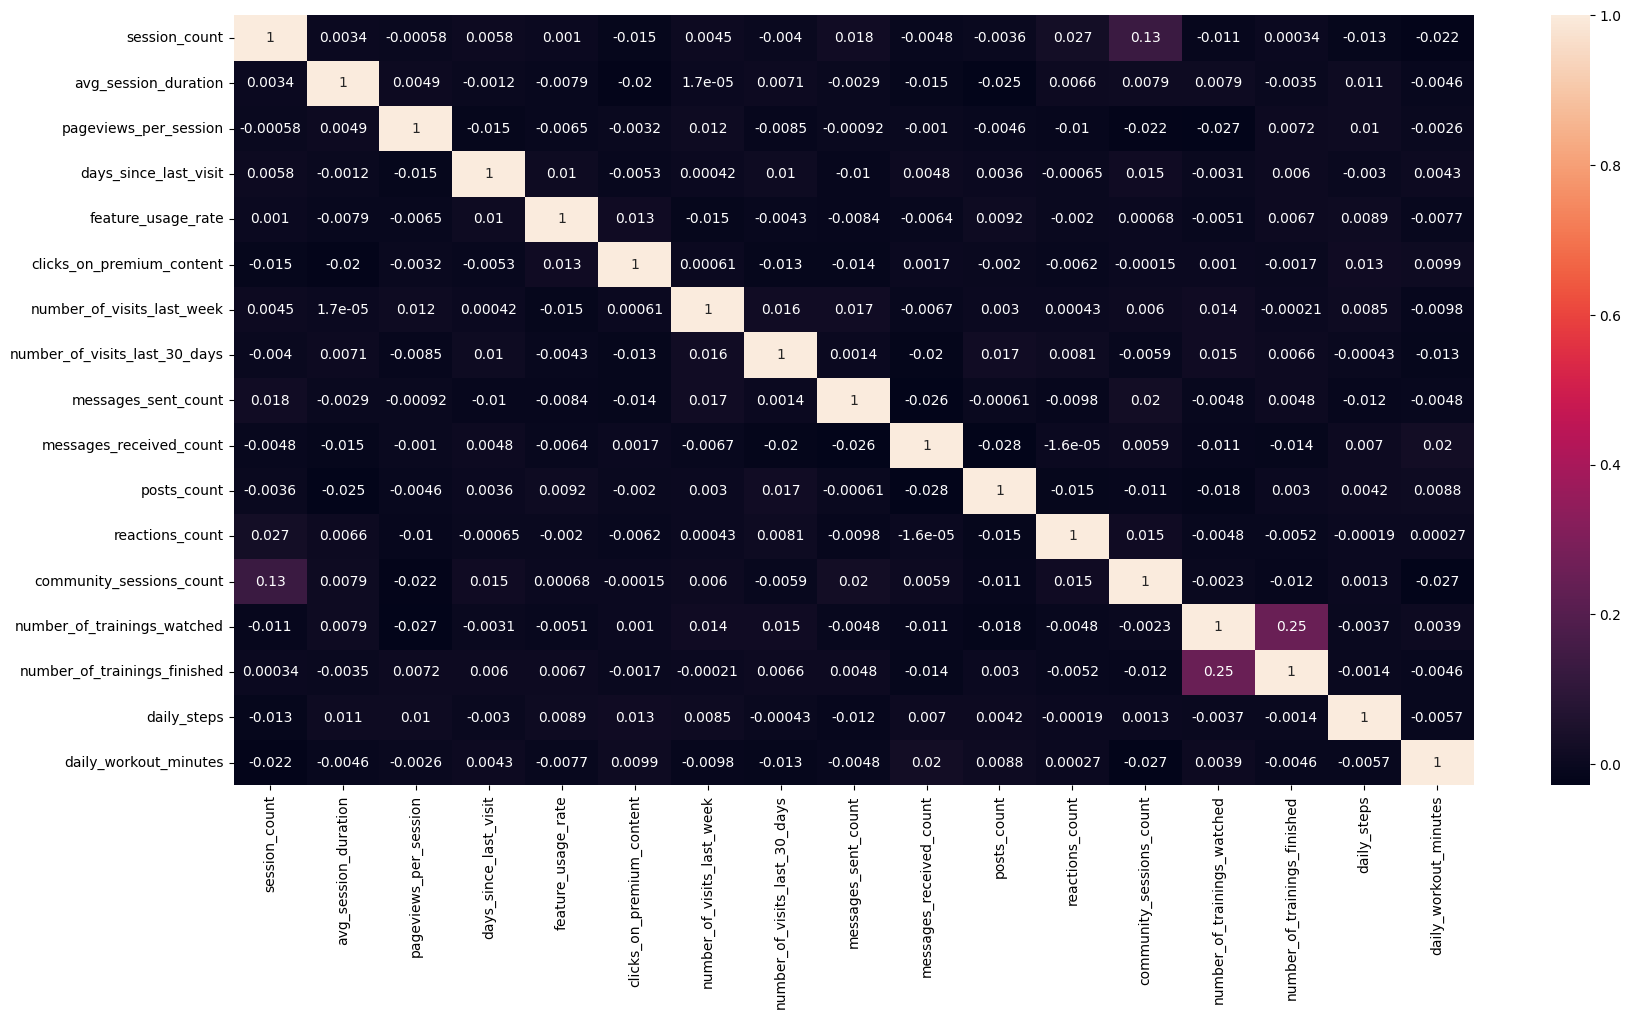

In [125]:
plt.figure(figsize=(20,10))
sns.heatmap(data[features].corr(), annot=True)

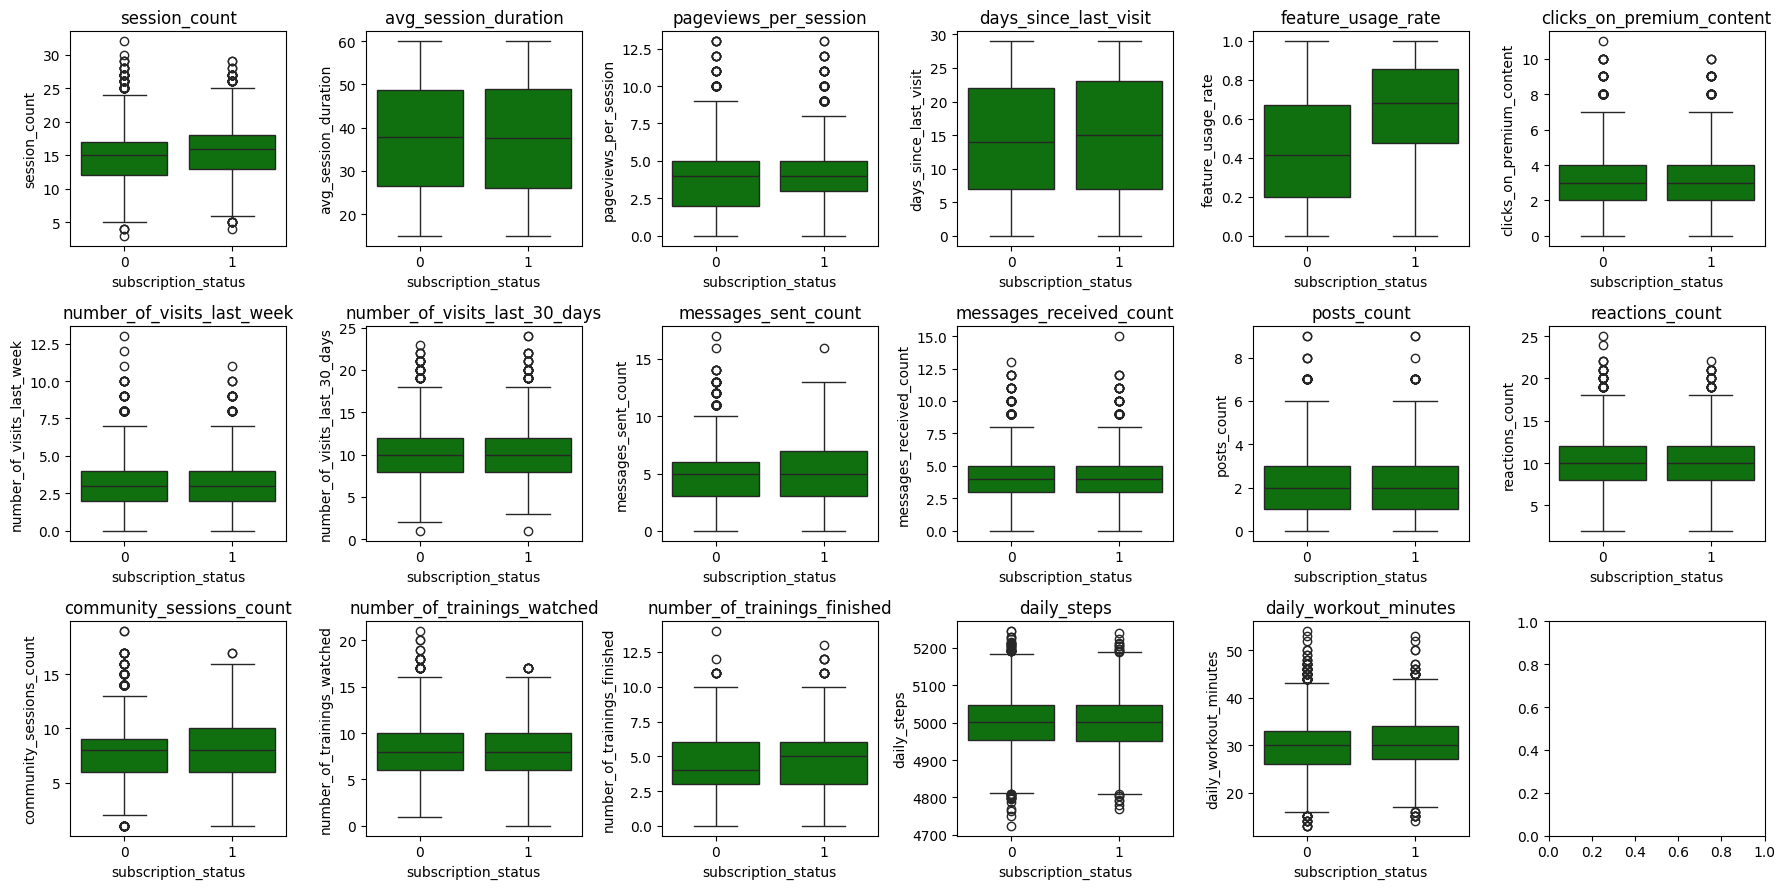

In [188]:
fig, axes = plt.subplots(3,6, figsize=(18,9))

for feature, ax in zip(features, axes.ravel()):
    sns.boxplot(x='subscription_status', y=feature, data=data, ax=ax, color='green')
    ax.set_title(feature)

plt.tight_layout()

In [189]:
cat_features = ['referral_source', 'state', 'device_type']
for feature in cat_features:
    print(data.groupby(feature)['subscription_status'].mean())
    print()

referral_source
ad          0.277580
organic     0.288141
referral    0.275367
Name: subscription_status, dtype: float64

state
California    0.270553
Florida       0.281836
Illinois      0.271985
New York      0.290372
Texas         0.288092
Name: subscription_status, dtype: float64

device_type
desktop    0.270981
mobile     0.289776
tablet     0.280665
Name: subscription_status, dtype: float64



## 3. Pre-processing & Feature engineering

In [190]:
data['trainings_complete_rate'] = data['number_of_trainings_finished'] / data['number_of_trainings_watched']
data.fillna(0, inplace=True)

In [191]:
X = data.drop(columns=['subscription_status','user_id'])
y = data['subscription_status']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


## 3. Model training

### 3.1 Logistic Regression

In [232]:
model = LogisticRegression(class_weight='balanced', random_state=111)

model.fit(X_train_scaled, y_train)

print(classification_report(y_test, model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      1439
           1       0.45      0.70      0.54       561

    accuracy                           0.67      2000
   macro avg       0.65      0.68      0.64      2000
weighted avg       0.74      0.67      0.69      2000



In [231]:
logclf = LogisticRegression(solver='liblinear', C=0.01, class_weight='balanced', random_state=42)

selector = RFE(logclf, n_features_to_select=10)
selector = selector.fit(X_train_scaled, y_train)

X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

logclf.fit(X_train_selected, y_train)

y_pred_log = logclf.predict(X_test_selected)
y_pred_prob_log = logclf.predict_proba(X_test_selected)

# Classification report
print()
print('Classification report:')
print(classification_report(y_test, y_pred_log))

# AUC score 
auc = roc_auc_score(y_test, y_pred_prob_log[:,1])
print('AUC score = ', auc) 


Classification report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75      1439
           1       0.46      0.73      0.57       561

    accuracy                           0.69      2000
   macro avg       0.66      0.70      0.66      2000
weighted avg       0.75      0.69      0.70      2000

AUC score =  0.7584118997273557


In [233]:
# bagging 
bagging_model = BaggingClassifier(logclf, n_estimators=10, random_state=42)

bagging_model.fit(X_train_selected, y_train)

y_pred_bag = bagging_model.predict(X_test_selected)
y_pred_prob_bag = bagging_model.predict_proba(X_test_selected)

# AUC score 
auc = roc_auc_score(y_test, y_pred_prob_bag[:,1])
print('AUC score = ', auc) 

# Classification report
print()
print('Classification report:')
print(classification_report(y_test, y_pred_bag))

AUC score =  0.7578135935655453

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.76      1439
           1       0.46      0.73      0.57       561

    accuracy                           0.69      2000
   macro avg       0.66      0.70      0.66      2000
weighted avg       0.75      0.69      0.70      2000



### 3.2 Random Forest

In [242]:
rfrc = RandomForestClassifier(n_estimators=500, min_samples_leaf=0.15, class_weight='balanced', random_state=42)

rfrc.fit(X_train_scaled, y_train)

y_pred_rf = rfrc.predict(X_test_scaled)
y_pred_prob_rf = rfrc.predict_proba(X_test_scaled)

# Classification reprot 
print()
print('Classification report:')
print(classification_report(y_test, y_pred_rf))

# AUC score 
auc_rf = roc_auc_score(y_test, y_pred_prob_rf[:,1])
print('AUC score = ', auc_rf)



Classification report:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67      1439
           1       0.40      0.79      0.53       561

    accuracy                           0.61      2000
   macro avg       0.64      0.67      0.60      2000
weighted avg       0.74      0.61      0.63      2000

AUC score =  0.7290924203404275


### 3.3 XGboost

In [198]:
xgbclf = xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'logloss', scale_pos_weight=2,
                           use_label_encoder=False, random_state=42)

xgbclf.fit(X_train_scaled, y_train)

y_pred_xgb = xgbclf.predict(X_test_scaled)
y_pred_prob_xgb = xgbclf.predict_proba(X_test_scaled)

# AUC score
auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb[:,1])
print('AUC score = ', auc_xgb)

# Classification reprot 
print()
print('Classification report:')
print(classification_report(y_test, y_pred_xgb))

AUC score =  0.7105374969496295

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      1439
           1       0.47      0.28      0.35       561

    accuracy                           0.71      2000
   macro avg       0.61      0.58      0.58      2000
weighted avg       0.68      0.71      0.68      2000



C:\Users\VanDoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [16:57:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Fine tuning

In [212]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

lr_cv = RandomizedSearchCV(logclf, param_grid_lr,
    scoring='recall', # optimize for recall as cost of false negative is high (activating a customer earlier = higher CLV)
    cv=5,
    verbose=1
)

lr_cv.fit(X_train_selected, y_train)

print(lr_cv.best_params_, lr_cv.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'solver': 'lbfgs', 'C': 0.1} 0.6825823258033725


In [211]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],                                   
    'min_samples_leaf': [0.01, 0.05, 0.1, 0.15],
    'class_weight': ['balanced', 'balanced_subsample']                     
}

rf_cv = RandomizedSearchCV(rfrc, param_grid_rf, scoring='recall', cv=5, n_iter=30, verbose=1, n_jobs=-1)
rf_cv.fit(X_train_scaled, y_train)

print(rf_cv.best_params_, rf_cv.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_estimators': 500, 'min_samples_leaf': 0.15, 'class_weight': 'balanced_subsample'} 0.7601485443843462
